In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better. If `max_epoch` is provided, will
    only report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [24]:
def print_profile_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [25]:
noprior_vals = print_profile_losses("GATA2")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 13
	Associated value: 107.96219924615355
Best epoch in each run:
	Run 1, epoch 13: 107.96
	Run 2, epoch 12: 108.49
	Run 3, epoch 16: 108.07
	Run 4, epoch 20: 108.10
	Run 5, epoch 17: 108.37
	Run 6, epoch 15: 108.29
	Run 7, epoch 17: 108.84
	Run 8, epoch 18: 108.74
	Run 9, epoch 18: 108.41
	Run 10, epoch 16: 108.37
All validation profile and prior losses:
1
	113.16 109.13 107.71 107.00 106.60 106.41 106.21 106.09 105.96 105.84 105.79 105.72 105.64 105.60 105.56
	112.21 110.52 109.57 109.24 108.77 108.50 108.30 108.22 108.20 108.06 108.17 108.00 107.96 108.08 107.97
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	113.40 109.13 108.00 107.32 106.84 106.52 106.24 106.07 105.94 105.81 105.73 105.65 105.60 105.53 105.51 105.46 105.40
	112.51 110.93 110.12 109.88 109.49 109.03 108.89 108.70 108.71 108.65 108.51 108.49 108.53 108.50 108.59 108.54 108.56
	0.0000 0.0000 0.0000

In [26]:
prior_vals = print_profile_losses("GATA2_prior")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 18
	Associated value: 108.64256467235332
Best epoch in each run:
	Run 1, epoch 18: 108.64
	Run 2, epoch 19: 108.73
	Run 3, epoch 20: 109.13
All validation profile and prior losses:
1
	116.35 111.96 110.06 109.26 108.52 107.86 107.38 107.03 106.83 106.68 106.59 106.52 106.44 106.38 106.31 106.26 106.17 106.14 106.15 106.10
	116.09 113.15 112.10 111.17 110.69 110.04 109.50 109.40 109.36 109.35 109.14 108.97 108.93 108.83 108.82 108.85 108.66 108.64 108.70 108.95
	0.1657 0.1597 0.1554 0.0655 0.0588 0.0556 0.0568 0.0532 0.0528 0.0527 0.0503 0.0541 0.0522 0.0485 0.0488 0.0474 0.0467 0.0456 0.0442 0.0461
2
	116.92 113.36 110.80 109.14 108.30 107.70 107.19 106.81 106.54 106.38 106.27 106.23 106.15 106.11 106.05 106.02 105.98 105.95 105.93 105.89
	117.35 114.90 112.31 111.24 110.66 110.03 109.65 109.35 109.22 109.08 108.91 108.96 108.77 109.02 108.81 108.85 108.73 108.77 108.73 108.73
	0.1197 0.0659 0.0659 0.0558 0.0461 0.0451 0.0449 

In [ ]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

In [28]:
def print_binary_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [41]:
noprior_vals = print_binary_losses("SPI1")

Best validation loss overall:
	Best run: 17
	Best epoch in run: 2
	Associated value: 0.2657462121730868
Best epoch in each run:
	Run 1, epoch 2:  0.274
	Run 2, epoch 2:  0.279
	Run 3, epoch 2:  0.275
	Run 4, epoch 2:  0.268
	Run 5, epoch 2:  0.272
	Run 6, epoch 2:  0.271
	Run 7, epoch 2:  0.278
	Run 8, epoch 2:  0.272
	Run 9, epoch 2:  0.276
	Run 10, epoch 1:  0.277
	Run 11, epoch 2:  0.272
	Run 12, epoch 2:  0.271
	Run 13, epoch 2:  0.270
	Run 14, epoch 2:  0.281
	Run 15, epoch 2:  0.278
	Run 16, epoch 1:  0.280
	Run 17, epoch 2:  0.266
	Run 18, epoch 2:  0.271
	Run 19, epoch 2:  0.272
All validation profile and prior losses:
1
	 0.290  0.239  0.218  0.203  0.191
	 0.281  0.274  0.282  0.295  0.313
	 0.000  0.000  0.000  0.000  0.000
2
	 0.289  0.242  0.223  0.207  0.194
	 0.283  0.279  0.285  0.304  0.314
	 0.000  0.000  0.000  0.000  0.000
3
	 0.292  0.242  0.221  0.206  0.193
	 0.280  0.275  0.284  0.292  0.308
	 0.000  0.000  0.000  0.000  0.000
4
	 0.286  0.236  0.217  0.203  0.1

In [42]:
prior_vals = print_binary_losses("SPI1_prior")

Best validation loss overall:
	Best run: 1
	Best epoch in run: 4
	Associated value: 0.2703861015471767
Best epoch in each run:
	Run 1, epoch 4:  0.270
	Run 2, epoch 3:  0.273
	Run 3, epoch 5:  0.273
	Run 4, epoch 8:  0.275
All validation profile and prior losses:
1
	 0.339  0.280  0.261  0.243  0.235  0.227  0.219
	 0.295  0.283  0.274  0.270  0.273  0.277  0.278
	 0.035  0.032  0.033  0.030  0.035  0.032  0.033
2
	 0.350  0.272  0.255  0.242  0.234  0.228  0.222  0.217  0.210
	 0.300  0.282  0.273  0.275  0.275  0.275  0.278  0.283  0.291
	 0.034  0.034  0.030  0.030  0.031  0.031  0.030  0.030  0.034
3
	 0.322  0.265  0.248  0.238  0.228  0.221  0.215  0.211
	 0.303  0.277  0.274  0.284  0.273  0.274  0.280  0.280
	 0.034  0.028  0.030  0.037  0.029  0.028  0.032  0.033
4
	 0.335  0.271  0.252  0.246  0.238  0.227  0.226  0.234  0.217  0.211  0.204
	 0.294  0.289  0.276  0.292  0.276  0.277  0.277  0.275  0.278  0.285  0.292
	 0.038  0.035  0.035  0.044  0.034  0.040  0.040  0.033  0

-2.65347337937071
0.007256762865705637


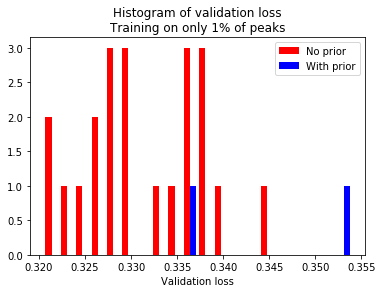

In [40]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss"
title += "\nTraining on only 1% of peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)